For the Botnet profiling task, we are going to use n-grams as our sequential method. Our approach is based on the CNG method (https://web.cs.dal.ca/~vlado/papers/pst04.pdf), where two training profiles are extracted corresponding to the two classes `infected` and `normal`. For the extraction of these two profiles we made use the first host from infected and normal hosts (147.32.84.165 and 147.32.84.170) respectively.

Next, we test our method on unseen host data, classifying them according to the CNG method. Further information will be given below.

The preprocessed file `capture20110818.pcap.netflow.labeled.remastered` has been used to avoid the issue with loading we faced in the Flow discretization task. The file is generated there.

In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from helper_functions.flow_data_discretization import *
from helper_functions.botnet_profiling_task import *

infected_hosts = ['147.32.84.165','147.32.84.191','147.32.84.192','147.32.84.193','147.32.84.204',
                  '147.32.84.205','147.32.84.206','147.32.84.207','147.32.84.208','147.32.84.209']

normal_hosts = ['147.32.84.170', '147.32.84.134', '147.32.84.164', '147.32.87.36', '147.32.80.9', '147.32.87.11']

test_hosts = np.append(infected_hosts[1:], normal_hosts[1:])
test_hosts = shuffle(test_hosts)
test_hosts

array(['147.32.87.36', '147.32.84.207', '147.32.84.164', '147.32.84.204',
       '147.32.84.134', '147.32.84.205', '147.32.84.206', '147.32.84.193',
       '147.32.84.208', '147.32.80.9', '147.32.87.11', '147.32.84.192',
       '147.32.84.191', '147.32.84.209'], dtype='<U13')

In [2]:
data = pd.read_csv('./data/capture20110818.pcap.netflow.labeled.remastered')
data[['Src_IP_Addr', 'Src_Port']] = data['Src_IP_Addr:Port'].str.split(':', n=1, expand=True)
data[['Dst_IP_Addr', 'Dst_Port']] = data['Dst_IP_Addr:Port'].str.split(':', n=1, expand=True)

data['Datetime'] = data['#Date_flow'].str.cat(data['start'], sep=' ')

data.drop(labels=['#Date_flow', 'start', 'Src_IP_Addr:Port', 'Dst_IP_Addr:Port'], axis=1, inplace=True)
data.head()

,Durat,Prot,Flags,Tos,Packets,Bytes,Flows,Label,Src_IP_Addr,Src_Port,Dst_IP_Addr,Dst_Port,Datetime
0,0.002,TCP,FRPA_,0,4,321,1,Background,147.32.86.166,33426,212.24.150.110,25443,2011-08-18 10:19:13.328
1,4.995,UDP,INT,0,617,40095,1,Background,82.39.2.249,41915,147.32.84.59,43087,2011-08-18 10:19:13.328
2,4.996,UDP,INT,0,1290,1909200,1,Background,147.32.84.59,43087,82.39.2.249,41915,2011-08-18 10:19:13.329
3,0.000,TCP,A_,0,1,66,1,Background,147.32.86.166,42020,147.32.192.34,993,2011-08-18 10:19:13.330
4,0.000,TCP,FPA_,0,2,169,1,Background,212.24.150.110,25443,147.32.86.166,33426,2011-08-18 10:19:13.330


NaNs do occur in features `Src_Port` and `Dst_Port` which will not be further utilized for this task. Hence, no further action is taken.

In [3]:
nans = data.isna().values
np.sum(nans, axis=0)

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0, 374017,      0, 375948,      0])

Remove background flows.

In [4]:
# remove background 
data_nobground = data[ data['Label'] != 'Background']
print("Shape: ", data_nobground.shape)

data_nobground.head()

Shape:  (645358, 13)


,Durat,Prot,Flags,Tos,Packets,Bytes,Flows,Label,Src_IP_Addr,Src_Port,Dst_IP_Addr,Dst_Port,Datetime
20,4.985,TCP,PA_,0,91,86277,1,LEGITIMATE,147.32.80.13,80,147.32.85.88,56949,2011-08-18 10:19:13.347
51,0.000,TCP,A_,0,1,66,1,LEGITIMATE,147.32.86.110,48102,74.125.232.214,443,2011-08-18 10:19:13.392
57,4.921,TCP,A_,0,49,3234,1,LEGITIMATE,147.32.85.88,56949,147.32.80.13,80,2011-08-18 10:19:13.411
73,4.742,TCP,A_,0,118,7080,1,LEGITIMATE,147.32.84.59,2768,74.125.108.208,80,2011-08-18 10:19:13.460
75,0.000,TCP,A_,0,1,60,1,LEGITIMATE,147.32.84.59,56058,74.125.232.215,443,2011-08-18 10:19:13.486


Discretize the `Prot` features as an enumeration of its unique values. **NOTE**: only protocols *TCP, UDP* and *ICMP* occur in the non-background data.

In [5]:
# Storing the mapping used for the conversion, in case we want to revert back 
label_mapping = {}

char_cols = ['Prot']

for c in char_cols:
    data_nobground[c], label_mapping[c] = pd.factorize(data_nobground[c])

# Uncomment this line, if you want to see the mapppings for the conversion
# label_mapping

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Discretize feature `Packets`, according to ordinal discretization found in https://ieeexplore.ieee.org/abstract/document/7987293 and add the extracted discrete feature `Disc_Packets` in the dataframe.

In [6]:
ranks = 2

packets = data_nobground['Packets'].values
data_nobground['Disc_Packets'] = discretize_ordinal(packets, ranks)

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


This is the training phase of our algorithm. Here, we extract the training profiles corresponding to the infected and the normal classes; the hosts 147.32.84.165 and 147.32.84.170 were used respectively. As host data, we consider the data where the considered host occurs either as host or destination. The features `Prot` and `Disc_Packets` are utilized and corresponding code values are extracted. Next, we apply a sliding window of a given length (in the current case of legnth 2) to extract the corresponding n-grams (sequences of code values). Finally, we extract the training profiles with the n-grams and their respective normalized frequency.

Tune the length of the sliding window, by changing `n`. Laplace smoothing has also been tested; you can use it by setting `use_smoothing=True`.

For further information on the utilized helper functions please refer to `helper_functions/botnet_profiling_task`.

In [7]:
n = 2 
feat = ['Prot', 'Disc_Packets']
use_smoothing = False

# Extracting the infected training profile
infected_data = data_nobground[np.logical_or(data_nobground['Src_IP_Addr'] == infected_hosts[0], data_nobground['Dst_IP_Addr']==infected_hosts[0])]
infected_data = infected_data[feat].values

infected_code, _ = extract_code(infected_data)
infected_ngrams = extract_ngrams(infected_code, n)
unique_infected_ngrams, unique_infected_counts = np.unique(infected_ngrams, axis=0, return_counts=True)
if use_smoothing:
    max_unigram = np.max(unique_infected_ngrams)
    smoothed_infected_ngrams, smoothed_infected_counts = laplace_smoothing(unique_infected_ngrams, unique_infected_counts, max_unigram)
    _, infected_prof, infected_sorted_prof = extract_profile(smoothed_infected_ngrams, smoothed_infected_counts)
else:
    _, infected_prof, infected_sorted_prof = extract_profile(unique_infected_ngrams, unique_infected_counts)

# Extracting the normal profile
normal_data = data_nobground[np.logical_or(data_nobground['Src_IP_Addr'] == normal_hosts[0], data_nobground['Dst_IP_Addr']==normal_hosts[0])]
normal_data = normal_data[feat].values

normal_code, _ = extract_code(normal_data)
normal_ngrams = extract_ngrams(normal_code, n)
unique_normal_ngrams, unique_normal_counts = np.unique(normal_ngrams, axis=0, return_counts=True)
if use_smoothing:
    smoothed_normal_ngrams, smoothed_normal_counts = laplace_smoothing(unique_normal_ngrams, unique_normal_counts, max_unigram)
    _, normal_prof, normal_sorted_prof = extract_profile(smoothed_normal_ngrams, smoothed_normal_counts)
else:
    _, normal_prof, normal_sorted_prof = extract_profile(unique_normal_ngrams, unique_normal_counts)

This is the same visualization offered in the Flow discretization task. It reveals an interesting aspect which will be exploited in the profiling. As seen, code values are much higher for the infected class, hence we expect the respective n-grams to be composed of higher values, comparing to the normal profile's n-grams.

Text(0, 0.5, 'Extracted code')

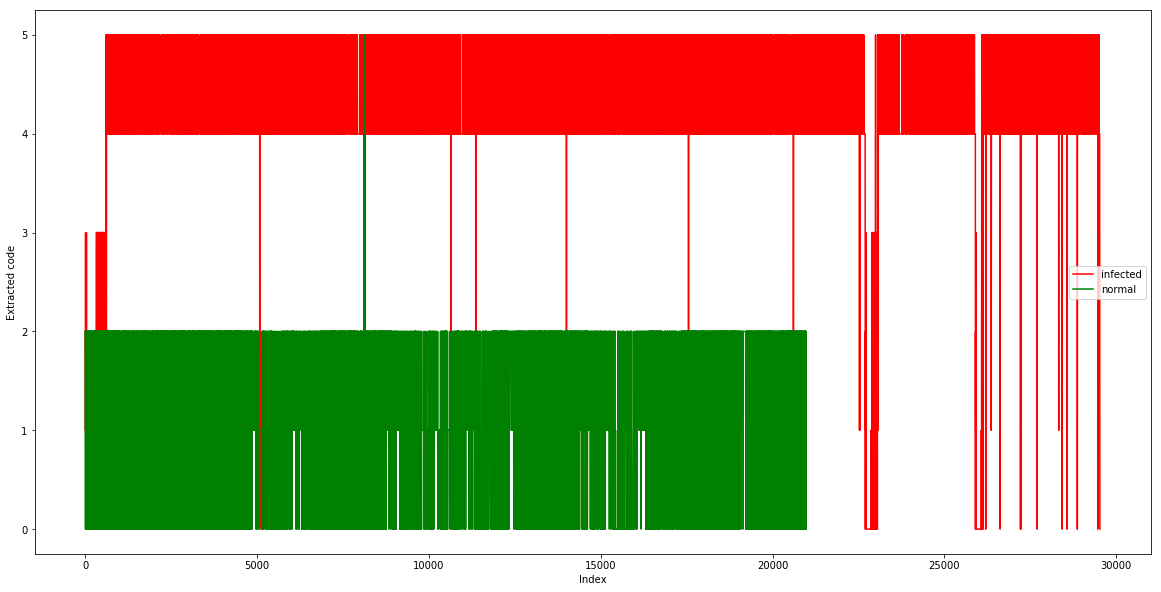

In [8]:
plt.figure(figsize=(20,10))
plt.plot(infected_code, color='r', label='infected')
plt.plot(normal_code, color='g', label='normal')
plt.legend()
plt.xlabel("Index")
plt.ylabel("Extracted code")

Here the profiling-classification of unseen hosts occurs. For the classification of each host, the respective profile is extracted. Then we compute the distance of the extracted host profile to the two training profiles, corresponding to the two classes. As a distance metric we used the distance of the CNG method defined in https://web.cs.dal.ca/~vlado/papers/pst04.pdf. Finally, we classify the host to the closest training profile (1-NearestNeighbour approach). From the profiles we only keep the 2 most frequent n-grams. This simple model as seen below suffices to detect every infected and normal host.

We also print the extracted distances for each host. The host 147.32.87.11 is skipped (classified as normal on default) as there are not enough data to extract sequence of the given length.

In [9]:
pred = np.zeros(len(test_hosts), dtype=int)
i=0
for host in test_hosts:
    host_data = data_nobground[np.logical_or(data_nobground['Src_IP_Addr'] == host, data_nobground['Dst_IP_Addr']==host)]
    if len(host_data)<n:
        i = i+1
        continue
    host_data = host_data[feat].values
    
    host_code, _ = extract_code(host_data)
    host_ngrams = extract_ngrams(host_code, n)
    unique_host_ngrams, unique_host_counts = np.unique(host_ngrams, axis=0, return_counts=True)
    if use_smoothing:
        smoothed_host_ngrams, smoothed_host_counts = laplace_smoothing(unique_host_ngrams, unique_host_counts, max_unigram)
        _, host_prof, sorted_host_prof = extract_profile(smoothed_host_ngrams, smoothed_host_counts)
    else:
        _, host_prof, sorted_host_prof = extract_profile(unique_host_ngrams, unique_host_counts)
    
    normal_distance = distance(normal_prof, host_prof, normal_sorted_prof, sorted_host_prof, 2)
    infected_distance = distance(infected_prof, host_prof, infected_sorted_prof, sorted_host_prof, 2)
    
    print(host, ', Normal:',  np.round(normal_distance, 3),', Infected:', np.round(infected_distance, 3))
    if infected_distance < normal_distance:
        
        pred[i] = 1

    i = i+1

147.32.87.36 , Normal: 1.544 , Infected: 4.119
147.32.84.207 , Normal: 6.067 , Infected: 0.018
147.32.84.164 , Normal: 0.782 , Infected: 6.623
147.32.84.204 , Normal: 6.464 , Infected: 0.206
147.32.84.134 , Normal: 1.346 , Infected: 7.104
147.32.84.205 , Normal: 6.585 , Infected: 0.33
147.32.84.206 , Normal: 6.177 , Infected: 0.041
147.32.84.193 , Normal: 5.882 , Infected: 0.032
147.32.84.208 , Normal: 6.532 , Infected: 0.281
147.32.80.9 , Normal: 13.046 , Infected: 14.104
147.32.84.192 , Normal: 6.364 , Infected: 0.128
147.32.84.191 , Normal: 6.373 , Infected: 0.134
147.32.84.209 , Normal: 5.9 , Infected: 0.004


As seen in the reported performance metrics our method manages to detect every normal and infected host. Similar performance was measured for increasing the width of the sliding window up to 7; after that gradually the number of FPs increased.

In [10]:
TP = np.sum(np.isin(test_hosts[pred==1], infected_hosts))
FP = np.sum(pred==1) - TP
TN = np.sum(np.isin(test_hosts[pred==0], infected_hosts, invert=True))
FN = np.sum(pred==0) - TN

cm = np.array([[TP, FP], [FN, TN]])
print('Confusion matrix: \n', cm)

acc, prec, rec, F1 = performance_metrics(cm)

print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)

Confusion matrix: 
 [[9 0]
 [0 5]]
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1_score: 1.000
